In [46]:
import string

import matplotlib.pyplot as plt
import numpy as np
import proplot
import xarray as xr

import plotting

from matplotlib.transforms import Affine2D

In [47]:
plotting.configure_style()

In [48]:
ds = xr.open_zarr("simulated_diurnal_cycles.zarr").load()
ds = ds - ds.mean("local_time_bin")  # Remove mean

In [49]:
COLORS = {
    "Fine resolution (year two)": ("#000000", "-"),
    "Baseline": ("#E69F00", "-"),
    "Nudged": ("#56B4E9", "-"),
    "ML-corrected seed 2": ("#009E73", "-"),
}
LABELS = {
    "Fine resolution (year two)": "Fine resolution",
    "Nudged": "Nudged",
    "Baseline": "Baseline",
    "ML-corrected seed 2": "ML-corrected seed 2"
}

In [50]:
rmse = np.sqrt(((ds - ds.sel(configuration="Fine resolution (year two)")) ** 2).mean("local_time_bin"))

In [54]:
# Based on https://matplotlib.org/stable/gallery/text_labels_and_annotations/rainbow_text.html
def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for i, (s, c) in enumerate(zip(strings, colors)):
        if i == len(strings) - 1:
            text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)
        else:
            text = ax.text(x, y, s + ",", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = text.get_transform() + Affine2D().translate(ex.width, 0)
        else:
            t = text.get_transform() + Affine2D().translate(0, ex.height)

In [55]:
def print_rmses(ax, rmse, region, climate, x, y):
    order = ["Baseline", "Nudged", "ML-corrected seed 2"]
    colors = ["#E69F00", "#56B4E9", "#009E73"]
    r = rmse.precipitation.sel(region=region, climate=climate)
    rmses = [f"{r.sel(configuration=configuration).item():0.1f}" for configuration in order]
    rainbow_text(x, y, rmses, colors, ax=ax)

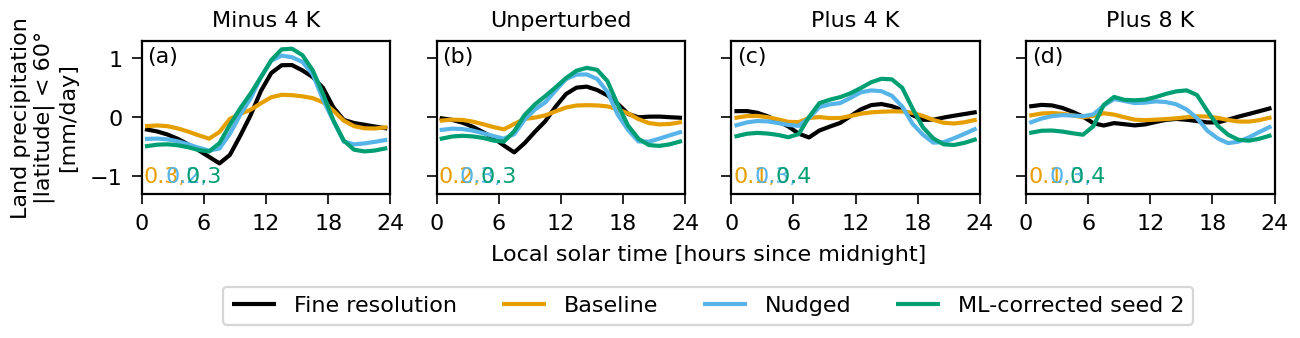

In [56]:
fig, axes = proplot.subplots(ncols=4, nrows=1, refaspect=1/0.618, figwidth=6.5)

for ax, letter, climate in zip(axes, string.ascii_lowercase, ["Minus 4 K", "Unperturbed", "Plus 4 K", "Plus 8 K"]):
    handles = []
    labels = []
    for configuration, (color, style) in COLORS.items():
        h = ds.precipitation.sel(climate=climate, region="land |lat| <= 60", configuration=configuration).plot(ax=ax, color=color, ls=style, add_legend=False)
        handles.append(h)
        labels.append(LABELS[configuration])
    ax.annotate(f"({letter})", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
    ax.set_title(climate)
    ax.set_xlabel("Local solar time [hours since midnight]")
    ax.set_ylabel(u"Land precipitation\n|latitude| < 60°\n[mm/day]")
    ax.set_xticks(np.arange(0, 25, 6))
    ax.set_xlim(0, 24)
    ax.set_ylim(-1.3, 1.3)
    print_rmses(ax, rmse, "land |lat| <= 60", climate, 0.2, -1.1)
    
fig.legend(handles, labels, loc="bottom", ncol=4)
fig.savefig("figures/figure-10.png", dpi=200)
fig.savefig("figures/figure-10.pdf")